In [1]:
import numpy as np
import pandas as pd
import pickle
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
import statsmodels.tsa.arima_model as am
from statsmodels.regression.rolling import RollingOLS

from tabulate import tabulate

import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.ticker import PercentFormatter


import os
import warnings

from scipy.optimize import minimize, brute
from arch import arch_model


warnings.filterwarnings("ignore")

In [2]:
covid_data = pd.read_csv('owid-covid-data.csv')

,location,total_deaths_per_million,gdp,total_cases_per_million,total_tests_per_thousand,stringency_index,density,population,poverty
25,Burundi,0.168,702.225,70.811,NaN,13.8689,423.062,1.18908e+07,71.7
49,Eritrea,0.282,1510.46,353.031,NaN,NaN,44.304,3.54643e+06,NaN
102,Mongolia,0.305,11840.8,398.988,NaN,NaN,1.98,3.27829e+06,0.5
150,Tanzania,0.352,2683.3,8.521,NaN,28.6787,64.699,5.97342e+07,49.1
164,Vietnam,0.36,6171.88,15.379,NaN,61.6633,308.127,9.73386e+07,2
151,Thailand,0.931,16277.7,128.453,NaN,54.6951,135.132,6.98e+07,0.1
120,Papua New Guinea,1.006,3823.19,89.303,NaN,44.4667,18.22,8.94703e+06,NaN
53,Fiji,2.231,8702.98,54.66,NaN,50.1615,49.562,896444,1.4
32,China,3.326,15308.7,66.869,NaN,71.9987,147.674,1.43932e+09,0.7
17,Benin,3.629,2064.24,268.164,NaN,47.207,99.11,1.21232e+07,49.6


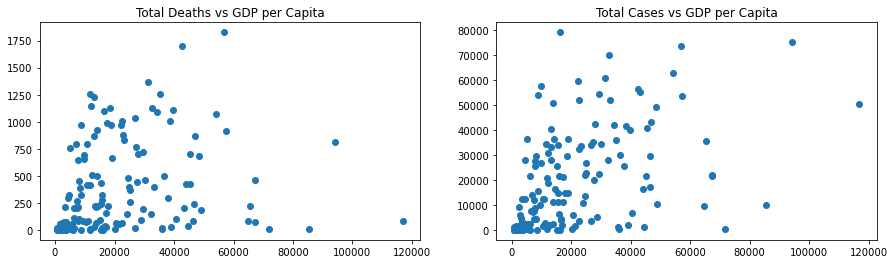

In [212]:
data_death = covid_data.dropna(subset = ['total_deaths_per_million','gdp_per_capita'])
countries = data_death.location.unique()
deaths = []
cases = []
gdp = []
tests = []
stringency = []
density = []
population = []
poverty = []
for c in countries:
    country_data = data_death[data_death.location == c]
    deaths.append(country_data.total_deaths_per_million.iloc[-1])
    gdp.append(country_data.gdp_per_capita.mean())
    cases.append(country_data.total_cases_per_million.iloc[-1])
    tests.append(country_data.total_tests_per_thousand.iloc[-1])
    stringency.append(country_data.stringency_index.mean())
    density.append(country_data.population_density.mean())
    population.append(country_data.population.mean())
    poverty.append(country_data.extreme_poverty.mean())
ans = pd.DataFrame([countries,deaths,gdp,cases,tests,stringency,density,population,poverty]).T
ans.columns = ['location','total_deaths_per_million','gdp',
               'total_cases_per_million','total_tests_per_thousand','stringency_index','density','population',
              'poverty']
fig,axs = plt.subplots(1, 2,figsize = (15,4))
axs[0].plot(ans['gdp'],ans['total_deaths_per_million'],'o',)
axs[0].set_title('Total Deaths vs GDP per Capita')
axs[1].plot(ans['gdp'],ans['total_cases_per_million'],'o')
axs[1].set_title('Total Cases vs GDP per Capita')
display(ans.sort_values(by = 'total_deaths_per_million')[:10])

## Why we picked Europe

In [94]:
import plotly.graph_objs as go
import plotly as py

In [165]:
data = dict (
    type = 'choropleth',
    locations = ans['location'],
    locationmode='country names',
    z=ans['total_deaths_per_million'],
    colorbar_title = "Total Deaths Per Million",colorscale = 'Reds')


fig = go.Figure(data=[data])
fig.update_layout(title=go.layout.Title(text="Total Deaths Per Million Map",
                                        font=go.layout.title.Font(size=15))
                 )
fig.show()

In [164]:
data = dict (
    type = 'choropleth',
    locations = ans['location'],
    locationmode='country names',
    z=ans['total_cases_per_million'],
    colorbar_title = "Total Cases Per Million",colorscale = 'Reds')


fig = go.Figure(data=[data])
fig.update_layout(title=go.layout.Title(text="Total Cases Per Million Map",
                                        font=go.layout.title.Font(size=15))
                 )
fig.show()

In [217]:
density = ans[['location','density']]

data = dict (
    type = 'choropleth',
    locations = ans['location'],
    locationmode='country names',
    z=ans['gdp'],
    colorbar_title = "GDP per Capita",colorscale = 'Reds')


fig = go.Figure(data=[data])
fig.update_layout(title=go.layout.Title(text="GDP per Capita Map",
                                        font=go.layout.title.Font(size=15))
                 )
fig.show()

In [188]:
data = dict (
    type = 'choropleth',
    locations = ans['location'],
    locationmode='country names',
    z=ans['stringency_index'],
    colorbar_title = "Average Stringency Index",colorscale = 'Reds')


fig = go.Figure(data=[data])
fig.update_layout(title=go.layout.Title(text="Stringency Index Map",
                                        font=go.layout.title.Font(size=15))
                 )
fig.show()

## Europe

In [219]:
eu = covid_data[covid_data.continent == 'Europe']

In [242]:
data_death = eu.dropna(subset = ['total_deaths_per_million','gdp_per_capita'])
countries = data_death.location.unique()
deaths = []
cases = []
gdp = []
tests = []
stringency = []
density = []
population = []
poverty = []
for c in countries:
    country_data = data_death[data_death.location == c]
    deaths.append(country_data.total_deaths_per_million.iloc[-1])
    gdp.append(country_data.gdp_per_capita.mean())
    cases.append(country_data.total_cases_per_million.iloc[-1])
    tests.append(country_data.total_tests_per_thousand.iloc[-1])
    stringency.append(country_data.stringency_index.mean())
    density.append(country_data.population_density.mean())
    population.append(country_data.population.mean())
    poverty.append(country_data.extreme_poverty.mean())
ans_eu = pd.DataFrame([countries,deaths,gdp,cases,tests,stringency,density,population,poverty]).T
ans_eu.columns = ['location','total_deaths_per_million','gdp',
               'total_cases_per_million','total_tests_per_thousand','stringency_index','density','population',
              'poverty']

In [243]:
ans_eu.iloc[:,1:] = ans_eu.iloc[:,1:].astype('float')

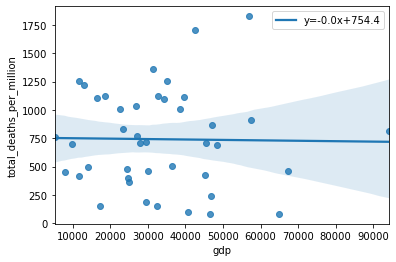

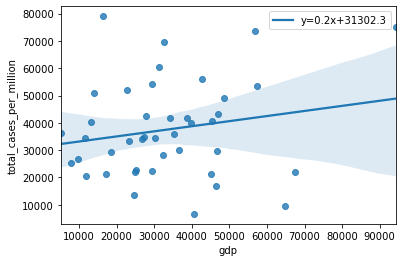

In [310]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ans_eu["gdp"].astype('float'),ans_eu["total_deaths_per_million"].astype('float'))

sns.regplot(x=ans_eu["gdp"].astype('float'), y=ans_eu["total_deaths_per_million"].astype('float'),
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.legend()

plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(ans_eu["gdp"].astype('float'),
                                                               y=ans_eu["total_cases_per_million"].astype('float'))
sns.regplot(x=ans_eu["gdp"].astype('float'), y=ans_eu["total_cases_per_million"].astype('float'),
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.legend()

plt.show()

## Days between first 100 cases and 1000 cases in EU

In [311]:
countries = eu.location.unique()
c = countries[0]
country_data = eu[eu.location== c].reset_index()

In [313]:
day_of_100 = []
day_of_1000 = []
human_index = []
policy_stringency_100 = []
policy_stringency_1000 = []
for c in countries:
    country_data = eu[eu.location== c].reset_index()
    country_data['day_of_100'] = 0
    country_data['day_of_1000'] = 0
    try:
        day_100 = country_data[country_data.total_cases_per_million > 100].first_valid_index()
        day_1000 = country_data[country_data.total_cases_per_million > 1000].first_valid_index()
        day_of_100.append(day_100)
        day_of_1000.append(day_1000)
    except:
        day_of_100.append(None)
        day_of_1000.append(None)
    
    try:
        human_index.append(country_data.human_development_index.mean())
        policy_stringency_100.append(country_data.stringency_index.loc[day_100])
        policy_stringency_1000.append(country_data.stringency_index.loc[day_1000])
    except:
        human_index.append(None)
        policy_stringency_100.append(None)
        policy_stringency_1000.append(None)

In [314]:
ans = pd.DataFrame([countries,day_of_100,day_of_1000,human_index,policy_stringency_100,policy_stringency_1000]).T
ans.columns = ['location','day_100','day_1000','human_index','policy_100','policy_1000']

In [315]:
ans['days_between'] = ans['day_1000'] - ans['day_100']
ans = ans.dropna()

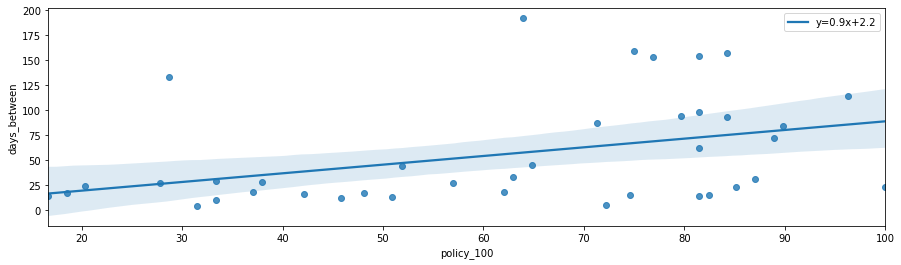

In [317]:
plt.figure(figsize = (15,4))

slope, intercept, r_value, p_value, std_err = stats.linregress(ans['policy_100'].astype('float'),
                                                               y=ans['days_between'].astype('float'))


sns.regplot(x=ans['policy_100'].astype('float'), y=ans['days_between'].astype('float'),
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.legend()

plt.show()

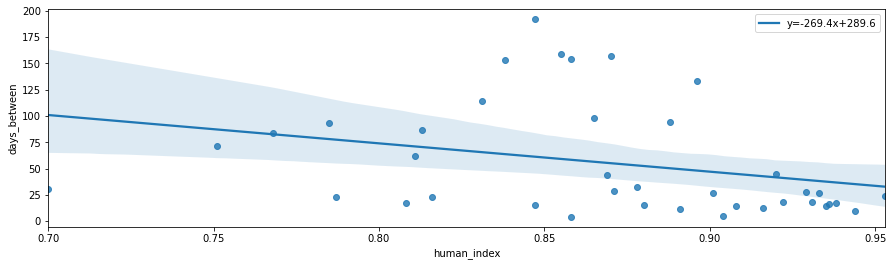

In [318]:
plt.figure(figsize = (15,4))

slope, intercept, r_value, p_value, std_err = stats.linregress(ans['human_index'].astype('float'),
                                                               y=ans['days_between'].astype('float'))


sns.regplot(x=ans['human_index'].astype('float'), y=ans['days_between'].astype('float'),
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.legend()

plt.show()